# 01. Understanding Self-Attention - GPT의 핵심

이 노트북에서는 GPT의 가장 중요한 컴포넌트인 **Self-Attention**을 단계별로 이해합니다.

## 목표
- Attention이 왜 필요한지 이해
- Query, Key, Value의 의미 파악
- 실제로 어떻게 계산되는지 확인

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# 시드 고정
torch.manual_seed(42)
np.random.seed(42)

## 1. 왜 Attention이 필요한가?

문장: "The cat sat on the mat"

- "it"이 나왔을 때 "cat"을 참조해야 함
- "mat"이 나왔을 때 "on"과의 관계를 이해해야 함

**Attention = 각 단어가 다른 단어들을 얼마나 '주목'하는지 학습**

In [12]:
# 간단한 예시: 4개 토큰의 임베딩
B = 1  # batch size
T = 4  # sequence length ("The cat sat on")
C = 8  # embedding dimension

# 랜덤 임베딩 (실제로는 학습된 값)
x = torch.randn(B, T, C)
print(f"입력 shape: {x.shape}")  # (1, 4, 8)
print(f"각 토큰은 {C}차원 벡터로 표현됨")

입력 shape: torch.Size([1, 4, 8])
각 토큰은 8차원 벡터로 표현됨


## 2. Query, Key, Value란?

각 토큰을 3가지 관점으로 변환:
- **Query (Q)**: "나는 무엇을 찾고 있나?"
- **Key (K)**: "나는 무엇을 제공하나?"
- **Value (V)**: "실제로 전달할 정보"

In [13]:
# Q, K, V 변환 행렬
head_size = 8
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)

# 변환
k = key(x)    # (B, T, head_size)
q = query(x)  # (B, T, head_size)
v = value(x)  # (B, T, head_size)

print(f"Query shape: {q.shape}")
print(f"Key shape: {k.shape}")
print(f"Value shape: {v.shape}")


Query shape: torch.Size([1, 4, 8])
Key shape: torch.Size([1, 4, 8])
Value shape: torch.Size([1, 4, 8])


## 3. Attention Score 계산

**핵심**: Query와 Key의 내적 = 얼마나 관련있는지

Attention scores shape: torch.Size([1, 4, 4])
각 토큰이 다른 모든 토큰과의 관계: 4x4 행렬


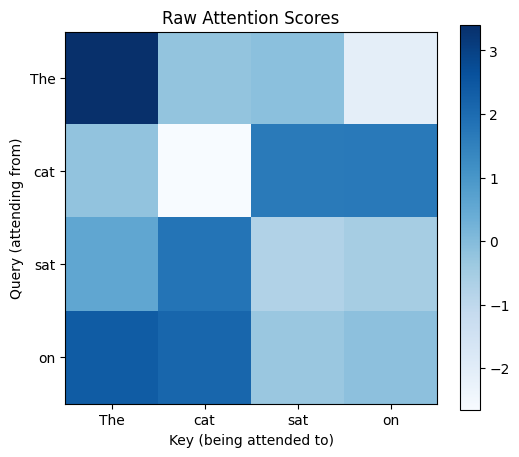

In [14]:
# Attention scores: Q @ K^T
scores = q @ k.transpose(-2, -1)  # (B, T, T)
print(f"Attention scores shape: {scores.shape}")
print(f"각 토큰이 다른 모든 토큰과의 관계: {T}x{T} 행렬")

# 시각화
plt.figure(figsize=(6, 5))
plt.imshow(scores[0].detach().numpy(), cmap='Blues')
plt.colorbar()
plt.xlabel('Key (being attended to)')
plt.ylabel('Query (attending from)')
plt.title('Raw Attention Scores')
tokens = ['The', 'cat', 'sat', 'on']
plt.xticks(range(4), tokens)
plt.yticks(range(4), tokens)
plt.show()

## 4. Scaled Dot-Product Attention

스케일링이 필요한 이유: 내적값이 너무 크면 softmax가 saturate됨

In [15]:
# 스케일링
scores_scaled = scores / np.sqrt(head_size)
print(f"스케일링 전 범위: [{scores.min():.2f}, {scores.max():.2f}]")
print(f"스케일링 후 범위: [{scores_scaled.min():.2f}, {scores_scaled.max():.2f}]")
print("scores_scaled: ", scores_scaled.shape)

# Softmax로 확률로 변환
attention_weights = F.softmax(scores_scaled, dim=-1)
print(f"\nAttention weights shape: {attention_weights.shape}")
print(f"각 행의 합: {attention_weights[0].sum(dim=-1)}")  # 모두 1.0

스케일링 전 범위: [-2.66, 3.40]
스케일링 후 범위: [-0.94, 1.20]
scores_scaled:  torch.Size([1, 4, 4])

Attention weights shape: torch.Size([1, 4, 4])
각 행의 합: tensor([1.0000, 1.0000, 1.0000, 1.0000], grad_fn=<SumBackward1>)


## 5. Causal Masking (GPT의 핵심)

**미래를 볼 수 없게 마스킹** - autoregressive 생성을 위해 필수

Causal mask:
tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
tril.shape:  torch.Size([4, 4])


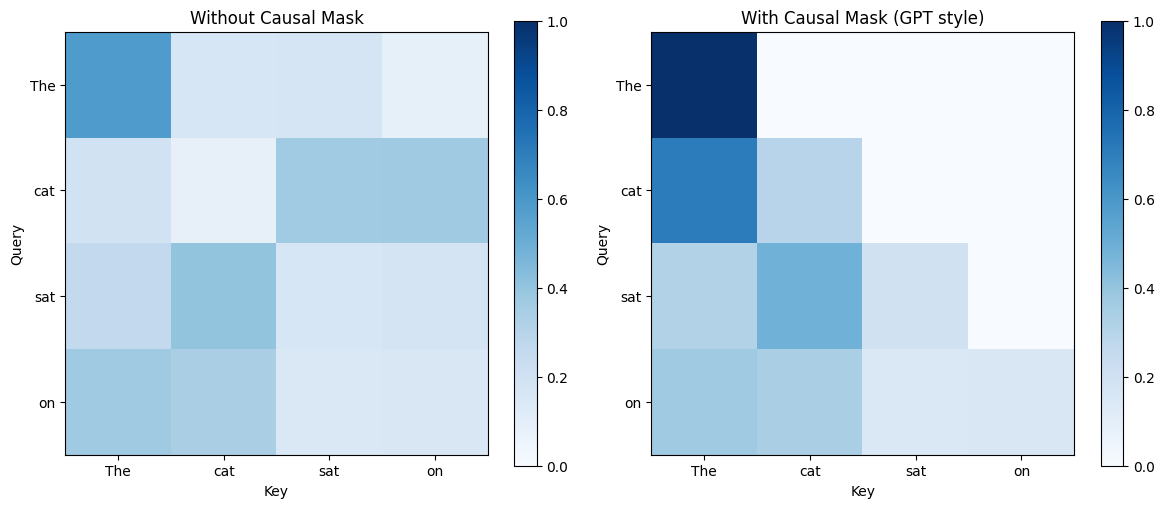


주목할 점:
- 'The'는 자기 자신만 볼 수 있음 (첫 번째)
- 'cat'은 'The'와 자신을 볼 수 있음
- 'sat'은 'The', 'cat', 자신을 볼 수 있음
- 'on'은 모든 이전 토큰을 볼 수 있음


In [16]:
# 하삼각 마스크 생성
tril = torch.tril(torch.ones(T, T))
print("Causal mask:")
print(tril)
print("tril.shape: ", tril.shape)

# 마스킹 적용 (미래 위치는 -inf로)
scores_masked = scores_scaled.masked_fill(tril == 0, float('-inf'))

# Softmax 후 확인
attention_weights_masked = F.softmax(scores_masked, dim=-1)

# 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# 마스킹 전
im1 = ax1.imshow(attention_weights[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
ax1.set_title('Without Causal Mask')
ax1.set_xlabel('Key')
ax1.set_ylabel('Query')
ax1.set_xticks(range(4))
ax1.set_xticklabels(tokens)
ax1.set_yticks(range(4))
ax1.set_yticklabels(tokens)
plt.colorbar(im1, ax=ax1)

# 마스킹 후
im2 = ax2.imshow(attention_weights_masked[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
ax2.set_title('With Causal Mask (GPT style)')
ax2.set_xlabel('Key')
ax2.set_ylabel('Query')
ax2.set_xticks(range(4))
ax2.set_xticklabels(tokens)
ax2.set_yticks(range(4))
ax2.set_yticklabels(tokens)
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("\n주목할 점:")
print("- 'The'는 자기 자신만 볼 수 있음 (첫 번째)")
print("- 'cat'은 'The'와 자신을 볼 수 있음")
print("- 'sat'은 'The', 'cat', 자신을 볼 수 있음")
print("- 'on'은 모든 이전 토큰을 볼 수 있음")

## 6. Value 집계 - 최종 출력

Attention weights를 사용해 Value를 가중 평균

In [18]:
# Value와 attention weights의 곱
print("attention_weights_masked: ", attention_weights_masked.shape)
print("v: ", v.shape)
out = attention_weights_masked @ v  # (B, T, head_size)
print(f"출력 shape: {out.shape}")
print(f"각 토큰이 관련 정보를 집계한 새로운 표현")

attention_weights_masked:  torch.Size([1, 4, 4])
v:  torch.Size([1, 4, 8])
출력 shape: torch.Size([1, 4, 8])
각 토큰이 관련 정보를 집계한 새로운 표현


## 7. 전체 Self-Attention 클래스

In [19]:
class SelfAttention(nn.Module):
    def __init__(self, embed_size, head_size):
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, head_size, bias=False)
        
    def forward(self, x):
        B, T, C = x.shape
        
        # Q, K, V 계산
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        # Attention scores
        scores = q @ k.transpose(-2, -1) * self.head_size**-0.5
        
        # Causal mask
        tril = torch.tril(torch.ones(T, T))
        scores = scores.masked_fill(tril == 0, float('-inf'))
        
        # Softmax
        att_weights = F.softmax(scores, dim=-1)
        
        # Value 집계
        out = att_weights @ v
        
        return out, att_weights

# 테스트
attention = SelfAttention(embed_size=8, head_size=8)
output, weights = attention(x)
print(f"Self-Attention 출력: {output.shape}")

Self-Attention 출력: torch.Size([1, 4, 8])


In [23]:
def attention_weighted_average():
    print("Attention에서의 가중 평균:")
    
    # 가상의 attention weights (가중치)
    att_weights = torch.tensor([
        [0.8, 0.2],  # 첫 번째 토큰의 attention weights
        [0.3, 0.7]   # 두 번째 토큰의 attention weights
    ])
    
    # 가상의 value (값)
    v = torch.tensor([
        [1.0, 0.0, 0.0],  # 첫 번째 토큰의 value
        [0.0, 1.0, 0.0]   # 두 번째 토큰의 value
    ])
    
    print(f"Attention Weights (가중치):")
    print(att_weights)
    print(f"\nValue (값):")
    print(v)
    
    # 행렬 곱셈
    out = att_weights @ v
    print(f"\n결과 (out = att_weights @ v):")
    print(out)
    
    print(f"\n각 행의 계산:")
    print(f"out[0] = {att_weights[0][0]}*{v[0]} + {att_weights[0][1]}*{v[1]} = {out[0]}")
    print(f"out[1] = {att_weights[1][0]}*{v[0]} + {att_weights[1][1]}*{v[1]} = {out[1]}")
    
    print(f"\n이것이 바로 가중 평균!")

attention_weighted_average()

Attention에서의 가중 평균:
Attention Weights (가중치):
tensor([[0.8000, 0.2000],
        [0.3000, 0.7000]])

Value (값):
tensor([[1., 0., 0.],
        [0., 1., 0.]])

결과 (out = att_weights @ v):
tensor([[0.8000, 0.2000, 0.0000],
        [0.3000, 0.7000, 0.0000]])

각 행의 계산:
out[0] = 0.800000011920929*tensor([1., 0., 0.]) + 0.20000000298023224*tensor([0., 1., 0.]) = tensor([0.8000, 0.2000, 0.0000])
out[1] = 0.30000001192092896*tensor([1., 0., 0.]) + 0.699999988079071*tensor([0., 1., 0.]) = tensor([0.3000, 0.7000, 0.0000])

이것이 바로 가중 평균!


## 8. Multi-Head Attention

여러 개의 attention head = 다양한 관점에서 관계 학습

In [20]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads
        
        # 여러 개의 attention head
        self.heads = nn.ModuleList([
            SelfAttention(embed_size, self.head_size) 
            for _ in range(num_heads)
        ])
        
        # 출력 projection
        self.proj = nn.Linear(embed_size, embed_size)
        
    def forward(self, x):
        # 각 head의 출력을 연결
        head_outputs = []
        attention_weights = []
        
        for head in self.heads:
            out, att = head(x)
            head_outputs.append(out)
            attention_weights.append(att)
        
        # Concatenate
        out = torch.cat(head_outputs, dim=-1)
        out = self.proj(out)
        
        return out, attention_weights

# 4개 head 사용
mha = MultiHeadAttention(embed_size=8, num_heads=4)
mha_output, mha_weights = mha(x)

print(f"Multi-Head Attention 출력: {mha_output.shape}")
print(f"Head 개수: {len(mha_weights)}")
print(f"각 head는 다른 패턴을 학습함")

Multi-Head Attention 출력: torch.Size([1, 4, 8])
Head 개수: 4
각 head는 다른 패턴을 학습함


## 9. 각 Head가 학습하는 패턴 시각화

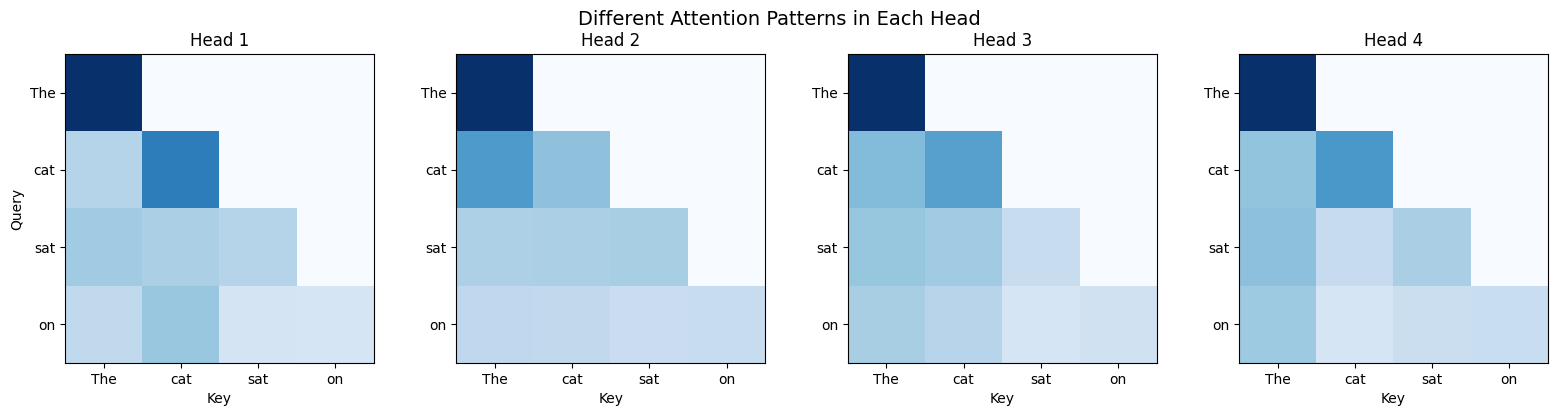

각 head는 다른 관계를 포착:
- Head 1: 문법적 관계 (주어-동사)
- Head 2: 의미적 관계 (명사들)
- Head 3: 순서 관계 (인접 단어)
- Head 4: 장거리 의존성


In [21]:
# 4개 head의 attention 패턴 비교
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i, (ax, weights) in enumerate(zip(axes, mha_weights)):
    im = ax.imshow(weights[0].detach().numpy(), cmap='Blues', vmin=0, vmax=1)
    ax.set_title(f'Head {i+1}')
    ax.set_xlabel('Key')
    if i == 0:
        ax.set_ylabel('Query')
    ax.set_xticks(range(4))
    ax.set_xticklabels(tokens)
    ax.set_yticks(range(4))
    ax.set_yticklabels(tokens)

plt.suptitle('Different Attention Patterns in Each Head', fontsize=14)
plt.tight_layout()
plt.show()

print("각 head는 다른 관계를 포착:")
print("- Head 1: 문법적 관계 (주어-동사)")
print("- Head 2: 의미적 관계 (명사들)")
print("- Head 3: 순서 관계 (인접 단어)")
print("- Head 4: 장거리 의존성")

## 💡 핵심 인사이트

1. **Attention = 관계 학습**
   - 각 토큰이 다른 토큰들과의 관계를 학습
   - Query-Key 매칭으로 중요도 결정

2. **Causal Masking = 미래 차단**
   - GPT는 autoregressive: 이전 토큰만 보고 다음 예측
   - 학습과 생성이 일치하도록 마스킹 필수

3. **Multi-Head = 다양한 관점**
   - 단일 attention은 한 가지 패턴만 학습
   - 여러 head로 풍부한 표현 학습

4. **스케일링 = 안정적 학습**
   - √d_k로 나누어 gradient 안정화
   - Softmax saturation 방지

## 🚀 다음 단계

이제 Self-Attention을 이해했으니:
1. **02_building_gpt_block.ipynb**: Transformer Block 구성
2. **03_text_generation.ipynb**: 텍스트 생성 과정 이해